# Document Clustering and Topic Modeling

In this project, I use unsupervised learning models to cluster unlabeled synopses of Top 100 [Greatest Movies of All Time from IMDB](https://www.imdb.com/list/ls055592025/) into different groups, visualize the results and identify their latent topics/structures.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

Read data from files. In summary, the data have 100 titles and 100 synoposes (combined from imdb and wiki).

In [2]:
#import three lists: titles and wikipedia synopses
titles = open('input/title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('input/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('input/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#just need to generate a list of ordered numbers for future usage.
ranks = range(1, len(titles)+1)

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [3]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print(stopwords[:10])

We use 153 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']


In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
tokenization_and_stemming("she looked at her father's arm.")

['look', 'father', "'s", 'arm']

Use the defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [6]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [7]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print(vocab_frame_dict['angel'])

angeles


# Part 3: TF-IDF

In [8]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 100 synoposes and 538 terms.


In [9]:
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming(text)>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [10]:
tf_selected_words = tfidf_model.get_feature_names()

# Calculate Document Similarity

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print(cos_matrix)

[[1.         0.1996283  0.23342595 ... 0.3581728  0.3277855  0.17714484]
 [0.1996283  1.         0.26626879 ... 0.26910321 0.22856581 0.10870124]
 [0.23342595 0.26626879 1.         ... 0.27738654 0.24669308 0.12805055]
 ...
 [0.3581728  0.26910321 0.27738654 ... 1.         0.55040973 0.08151334]
 [0.3277855  0.22856581 0.24669308 ... 0.55040973 1.         0.13005234]
 [0.17714484 0.10870124 0.12805055 ... 0.08151334 0.13005234 1.        ]]


# Part 4: K-means clustering

In [12]:
from sklearn.cluster import KMeans

num_clusters = 4
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [13]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

In [14]:
frame.head(10)

,rank,title,cluster
3,1,The Godfather,3
3,2,The Shawshank Redemption,3
1,3,Schindler's List,1
0,4,Raging Bull,0
2,5,Casablanca,2
1,6,One Flew Over the Cuckoo's Nest,1
3,7,Gone with the Wind,3
2,8,Citizen Kane,2
3,9,The Wizard of Oz,3
3,10,Titanic,3


In [15]:
print("Number of films included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
2,36
3,33
1,20
0,11


In [16]:
grouped = frame['rank'].groupby(frame['cluster'])
print("Average rank (1 to 100) per cluster:")
grouped.mean().to_frame()

Average rank (1 to 100) per cluster:


,rank
cluster,
0,46.545455
1,42.950000
2,59.583333
3,46.484848


In [17]:
print("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print("Cluster " + str(i) + " words:" ,)
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print(vocab_frame_dict[tf_selected_words[ind]] + ",")
    print
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): " )
    print(", ".join(cluster_movies))

<Document clustering result by K-means>
Cluster 0 words:
singing,
new,
fight,
apartment,
friend,
bar,
Cluster 0 titles (11 movies): 
Raging Bull, On the Waterfront, Singin' in the Rain, Rocky, An American in Paris, Jaws, The Good, the Bad and the Ugly, The Apartment, Midnight Cowboy, Annie Hall, Nashville
Cluster 1 words:
soldiers,
army,
killing,
commanded,
orders,
war,
Cluster 1 titles (20 movies): 
Schindler's List, One Flew Over the Cuckoo's Nest, Lawrence of Arabia, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Raiders of the Lost Ark, Patton, Braveheart, Butch Cassidy and the Sundance Kid, Platoon, Dances with Wolves, The Deer Hunter, All Quiet on the Western Front, Stagecoach, Mutiny on the Bounty
Cluster 2 words:
police,
car,
killing,
father,
say,
mr.,
Cluster 2 titles (36 movies): 
Casablanca, Citizen Kane, P

It shows that the main topics of the 4 clusters of movies are:
killing, family, wars & love

## 4.2. Plot K-means Result

In [18]:
# use PCA to visualize the 2 principle components. 
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

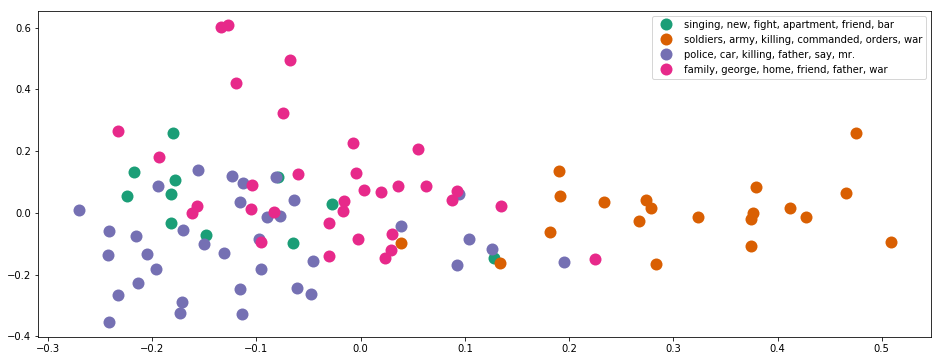

In [19]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 6))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=1)  #show legend with only 1 point, position is upper right. 

plt.show() #show the plot

# Part 5: Topic Modeling - Latent Dirichlet Allocation
I will use LDA to group the movies.

In [20]:
#Now use synopses to build a 100*551 matrix (terms)
terms_dict = {tf_selected_words[x]:x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i)
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_synopses_tf.append(current_doc_stats)
    
feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)

In [21]:
model = lda.LDA(n_topics=4, n_iter=500, random_state=42)

<li> "model.topic_word_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
<li> The shape of "model.topic_word_" is (n_topics,num_of_selected_words)
<li> "model.doc_topic_" saves the document topic results, i.e. document topic matrix.
<li> The shape of "model.doc_topic_" is (num_of_documents, n_topics)

In [22]:
model.fit(feature_matrix_synopses_tf)
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 7

topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 538
INFO:lda:n_words: 61218
INFO:lda:n_topics: 4
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -468275
INFO:lda:<10> log likelihood: -419126
INFO:lda:<20> log likelihood: -406304
INFO:lda:<30> log likelihood: -401554
INFO:lda:<40> log likelihood: -397861
INFO:lda:<50> log likelihood: -395310
INFO:lda:<60> log likelihood: -394295
INFO:lda:<70> log likelihood: -393199
INFO:lda:<80> log likelihood: -392362
INFO:lda:<90> log likelihood: -391746
INFO:lda:<100> log likelihood: -391167
INFO:lda:<110> log likelihood: -391029
INFO:lda:<120> log likelihood: -390754
INFO:lda:<130> log likelihood: -389672
INFO:lda:<140> log likelihood: -389680
INFO:lda:<150> log likelihood: -389629
INFO:lda:<160> log likelihood: -389268
INFO:lda:<170> log likelihood: -389463
INFO:lda:<180> log likelihood: -389061
INFO:lda:<190> log likelihood: -389237
INFO:lda:<200> log likelihood: -389228
INFO:lda:<210> log likelihood: -388704
INFO:lda:<220> log likelihood: -3886

In [23]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

print("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print('==============================')
    print("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): " )
    print(', '.join(topic_doc_dict[i]))

<Document clustering result by LDA>
Cluster 1 words: father, family, george, love, working, filmed
Cluster 1 titles (24 movies): 
The Godfather, Raging Bull, Gone with the Wind, Citizen Kane, The Godfather: Part II, The Sound of Music, Singin' in the Rain, It's a Wonderful Life, Amadeus, Gandhi, A Streetcar Named Desire, The Philadelphia Story, An American in Paris, The Best Years of Our Lives, Braveheart, City Lights, The King's Speech, A Place in the Sun, Mr. Smith Goes to Washington, Annie Hall, Good Will Hunting, Terms of Endearment, Giant, Yankee Doodle Dandy
Cluster 3 words: asks, say, n't, killing, friend, goes
Cluster 3 titles (33 movies): 
The Shawshank Redemption, Casablanca, One Flew Over the Cuckoo's Nest, Psycho, On the Waterfront, West Side Story, 2001: A Space Odyssey, Chinatown, Some Like It Hot, 12 Angry Men, Unforgiven, Rocky, To Kill a Mockingbird, Jaws, The Apartment, The Deer Hunter, Tootsie, Fargo, The Grapes of Wrath, Shane, The Green Mile, Close Encounters of th